In [1]:
!nvidia-smi

Thu Jun  1 20:15:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:89:00.0 Off |                  Off |
| N/A   28C    P0    40W / 300W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import nibabel as nib

from monai.apps import download_and_extract
from monai.config import print_config
from monai.utils import set_determinism

print_config()
set_determinism(0)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

/home/fastmri2/.conda/envs/snumvi/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


MONAI version: 1.1.0
Numpy version: 1.23.5
Pytorch version: 1.7.1+cu110
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/fastmri2/.conda/envs/snumvi/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 5.0.0
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.4.0
gdown version: 4.6.0
TorchVision version: 0.8.2+cu110
tqdm version: 4.65.0
lmdb version: 1.4.0
psutil version: 5.9.0
pandas version: 1.5.2
einops version: 0.6.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 2.1.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
directory = "temp"
if not os.path.exists(directory):
    os.makedirs(directory)
root_dir = tempfile.mkdtemp() if directory is None else directory
data_dir = "cropped"
uncropped_dir = "nifti"

In [4]:
patients = sorted(glob.glob(os.path.join(uncropped_dir, "*.nii.gz")))
print(len(patients))

246


In [5]:
patient_data = pd.read_excel("new_nifti_center2.xlsx", usecols=['patID', 'v_center', 'h_center', 'l_center']).set_index("patID").dropna()
print(patient_data)

       v_center  h_center  l_center
patID                              
1          88.0     133.0      60.0
2         113.0     185.0      67.0
3          81.0     209.0      39.0
7         175.0     280.0      78.0
10        180.0     259.0      40.0
...         ...       ...       ...
348       104.0     212.0      52.0
349       155.0     176.0      43.0
350       190.0     179.0      60.0
351       154.0     125.0      53.0
352       270.0     326.0      71.0

[231 rows x 3 columns]


In [6]:
def crop_nifti(input_file, output_dir, centre_coords, crop_size):
    image = nib.load(input_file)
    image_data = image.get_fdata()
    padding = tuple((crop, crop) for crop in crop_size)
    image_data = np.pad(image_data, padding, 'constant', constant_values=0)
    padded_center = tuple(centre + crop for centre, crop in zip(centre_coords, crop_size))
    start_coords = tuple(int(center - 0.5 * crop) for center, crop in zip(padded_center, crop_size))
    end_coords = tuple(start + crop for start, crop in zip(start_coords, crop_size))
    cropped_data = image_data[start_coords[0]:end_coords[0],
                              start_coords[1]:end_coords[1],
                              start_coords[2]:end_coords[2]]
    cropped_img = nib.Nifti1Image(cropped_data, image.affine, image.header)
    output_path = os.path.join(output_dir, ''.join(map(str, crop_size)), input_file.split('/')[-1])
    nib.save(cropped_img, output_path)
    print("Saved as", output_path)

In [7]:
%%time
#!mkdir cropped/707035
size = 160
crop_size = (size, size, size//2)

for patient in patients:
    patient_int = int(os.path.basename(patient).split('.')[0])
    try:
        crop_nifti(patient, data_dir, tuple(patient_data.loc[patient_int, "v_center":"l_center"]), crop_size)
    except KeyError:
        print('Cannot convert {}'.format(patient))

Saved as cropped/16016080/1.nii.gz
Saved as cropped/16016080/10.nii.gz
Cannot convert nifti/100.nii.gz
Saved as cropped/16016080/101.nii.gz
Saved as cropped/16016080/103.nii.gz
Saved as cropped/16016080/104.nii.gz
Saved as cropped/16016080/105.nii.gz
Saved as cropped/16016080/106.nii.gz
Saved as cropped/16016080/107.nii.gz
Saved as cropped/16016080/108.nii.gz
Saved as cropped/16016080/109.nii.gz
Saved as cropped/16016080/11.nii.gz
Saved as cropped/16016080/110.nii.gz
Saved as cropped/16016080/111.nii.gz
Saved as cropped/16016080/112.nii.gz
Saved as cropped/16016080/113.nii.gz
Saved as cropped/16016080/114.nii.gz
Saved as cropped/16016080/115.nii.gz
Saved as cropped/16016080/116.nii.gz
Saved as cropped/16016080/117.nii.gz
Saved as cropped/16016080/120.nii.gz
Saved as cropped/16016080/121.nii.gz
Saved as cropped/16016080/122.nii.gz
Saved as cropped/16016080/123.nii.gz
Saved as cropped/16016080/124.nii.gz
Saved as cropped/16016080/125.nii.gz
Saved as cropped/16016080/127.nii.gz
Saved as c

In [8]:
new_data_dir = os.path.join(data_dir, ''.join(map(str, crop_size)))
new_patients = sorted(glob.glob(os.path.join(new_data_dir, "*.nii.gz")))
print(len(new_patients))

231


In [9]:
def nii_loader(filename) :
    nimg = nib.load(filename)
    return nimg.get_fdata() , nimg.affine, nimg.header

def visualize_all(dataset, cols, idxs, target_layer=10):
    import random
    fig = plt.figure()
    rows = len(idxs)//cols + 1
    i = 1
    for idx in idxs:
        image = dataset[idx]
        print(idx + 1, image)
        image_data, image_affine, image_header = nii_loader(image)
        target_image = image_data[:,:,target_layer]
        sub_fig = fig.add_subplot(rows, cols, i)
        sub_fig.get_xaxis().set_visible(False)
        sub_fig.get_yaxis().set_visible(False)
        sub_fig.imshow(target_image, cmap='gray')
        i += 1
    plt.show()

1 cropped/16016080/1.nii.gz
2 cropped/16016080/10.nii.gz
3 cropped/16016080/101.nii.gz
4 cropped/16016080/103.nii.gz
5 cropped/16016080/104.nii.gz
6 cropped/16016080/105.nii.gz
7 cropped/16016080/106.nii.gz
8 cropped/16016080/107.nii.gz
9 cropped/16016080/108.nii.gz
10 cropped/16016080/109.nii.gz
11 cropped/16016080/11.nii.gz
12 cropped/16016080/110.nii.gz
13 cropped/16016080/111.nii.gz
14 cropped/16016080/112.nii.gz
15 cropped/16016080/113.nii.gz
16 cropped/16016080/114.nii.gz
17 cropped/16016080/115.nii.gz
18 cropped/16016080/116.nii.gz
19 cropped/16016080/117.nii.gz
20 cropped/16016080/120.nii.gz
21 cropped/16016080/121.nii.gz
22 cropped/16016080/122.nii.gz
23 cropped/16016080/123.nii.gz
24 cropped/16016080/124.nii.gz
25 cropped/16016080/125.nii.gz
26 cropped/16016080/127.nii.gz
27 cropped/16016080/128.nii.gz
28 cropped/16016080/129.nii.gz
29 cropped/16016080/130.nii.gz
30 cropped/16016080/133.nii.gz
31 cropped/16016080/134.nii.gz
32 cropped/16016080/138.nii.gz
33 cropped/16016080/1

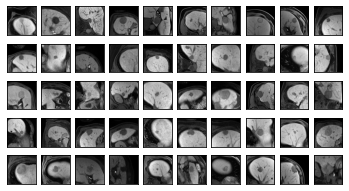

In [10]:
visualize_all(new_patients, 10, list(range(0, 50)), target_layer=crop_size[2]//2)

51 cropped/16016080/171.nii.gz
52 cropped/16016080/176.nii.gz
53 cropped/16016080/177.nii.gz
54 cropped/16016080/178.nii.gz
55 cropped/16016080/179.nii.gz
56 cropped/16016080/180.nii.gz
57 cropped/16016080/181.nii.gz
58 cropped/16016080/182.nii.gz
59 cropped/16016080/185.nii.gz
60 cropped/16016080/186.nii.gz
61 cropped/16016080/187.nii.gz
62 cropped/16016080/188.nii.gz
63 cropped/16016080/189.nii.gz
64 cropped/16016080/190.nii.gz
65 cropped/16016080/191.nii.gz
66 cropped/16016080/192.nii.gz
67 cropped/16016080/193.nii.gz
68 cropped/16016080/194.nii.gz
69 cropped/16016080/195.nii.gz
70 cropped/16016080/196.nii.gz
71 cropped/16016080/197.nii.gz
72 cropped/16016080/198.nii.gz
73 cropped/16016080/2.nii.gz
74 cropped/16016080/20.nii.gz
75 cropped/16016080/200.nii.gz
76 cropped/16016080/201.nii.gz
77 cropped/16016080/202.nii.gz
78 cropped/16016080/204.nii.gz
79 cropped/16016080/205.nii.gz
80 cropped/16016080/207.nii.gz
81 cropped/16016080/208.nii.gz
82 cropped/16016080/21.nii.gz
83 cropped/1

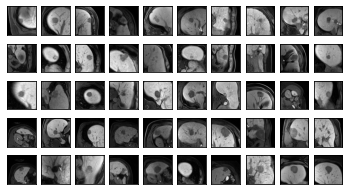

In [11]:
visualize_all(new_patients, 10, list(range(50, 100)), target_layer=crop_size[2]//2)

101 cropped/16016080/234.nii.gz
102 cropped/16016080/237.nii.gz
103 cropped/16016080/239.nii.gz
104 cropped/16016080/24.nii.gz
105 cropped/16016080/240.nii.gz
106 cropped/16016080/241.nii.gz
107 cropped/16016080/242.nii.gz
108 cropped/16016080/243.nii.gz
109 cropped/16016080/244.nii.gz
110 cropped/16016080/246.nii.gz
111 cropped/16016080/249.nii.gz
112 cropped/16016080/250.nii.gz
113 cropped/16016080/251.nii.gz
114 cropped/16016080/252.nii.gz
115 cropped/16016080/253.nii.gz
116 cropped/16016080/255.nii.gz
117 cropped/16016080/257.nii.gz
118 cropped/16016080/258.nii.gz
119 cropped/16016080/259.nii.gz
120 cropped/16016080/26.nii.gz
121 cropped/16016080/260.nii.gz
122 cropped/16016080/262.nii.gz
123 cropped/16016080/263.nii.gz
124 cropped/16016080/265.nii.gz
125 cropped/16016080/266.nii.gz
126 cropped/16016080/267.nii.gz
127 cropped/16016080/268.nii.gz
128 cropped/16016080/269.nii.gz
129 cropped/16016080/27.nii.gz
130 cropped/16016080/270.nii.gz
131 cropped/16016080/272.nii.gz
132 cropped

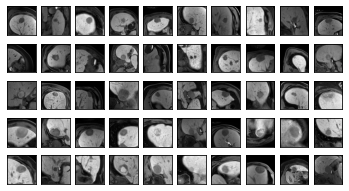

In [12]:
visualize_all(new_patients, 10, list(range(100, 150)), target_layer=crop_size[2]//2)

151 cropped/16016080/296.nii.gz
152 cropped/16016080/297.nii.gz
153 cropped/16016080/298.nii.gz
154 cropped/16016080/3.nii.gz
155 cropped/16016080/300.nii.gz
156 cropped/16016080/302.nii.gz
157 cropped/16016080/303.nii.gz
158 cropped/16016080/304.nii.gz
159 cropped/16016080/305.nii.gz
160 cropped/16016080/311.nii.gz
161 cropped/16016080/314.nii.gz
162 cropped/16016080/316.nii.gz
163 cropped/16016080/318.nii.gz
164 cropped/16016080/319.nii.gz
165 cropped/16016080/320.nii.gz
166 cropped/16016080/321.nii.gz
167 cropped/16016080/323.nii.gz
168 cropped/16016080/324.nii.gz
169 cropped/16016080/326.nii.gz
170 cropped/16016080/327.nii.gz
171 cropped/16016080/328.nii.gz
172 cropped/16016080/33.nii.gz
173 cropped/16016080/330.nii.gz
174 cropped/16016080/331.nii.gz
175 cropped/16016080/332.nii.gz
176 cropped/16016080/333.nii.gz
177 cropped/16016080/334.nii.gz
178 cropped/16016080/335.nii.gz
179 cropped/16016080/336.nii.gz
180 cropped/16016080/337.nii.gz
181 cropped/16016080/338.nii.gz
182 cropped

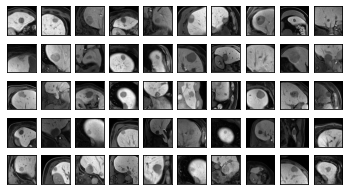

In [13]:
visualize_all(new_patients, 10, list(range(150, 200)), target_layer=crop_size[2]//2)

201 cropped/16016080/42.nii.gz
202 cropped/16016080/44.nii.gz
203 cropped/16016080/47.nii.gz
204 cropped/16016080/48.nii.gz
205 cropped/16016080/50.nii.gz
206 cropped/16016080/51.nii.gz
207 cropped/16016080/52.nii.gz
208 cropped/16016080/53.nii.gz
209 cropped/16016080/57.nii.gz
210 cropped/16016080/58.nii.gz
211 cropped/16016080/59.nii.gz
212 cropped/16016080/62.nii.gz
213 cropped/16016080/63.nii.gz
214 cropped/16016080/65.nii.gz
215 cropped/16016080/68.nii.gz
216 cropped/16016080/7.nii.gz
217 cropped/16016080/70.nii.gz
218 cropped/16016080/71.nii.gz
219 cropped/16016080/72.nii.gz
220 cropped/16016080/74.nii.gz
221 cropped/16016080/75.nii.gz
222 cropped/16016080/80.nii.gz
223 cropped/16016080/81.nii.gz
224 cropped/16016080/83.nii.gz
225 cropped/16016080/85.nii.gz
226 cropped/16016080/91.nii.gz
227 cropped/16016080/93.nii.gz
228 cropped/16016080/94.nii.gz
229 cropped/16016080/95.nii.gz
230 cropped/16016080/96.nii.gz
231 cropped/16016080/97.nii.gz


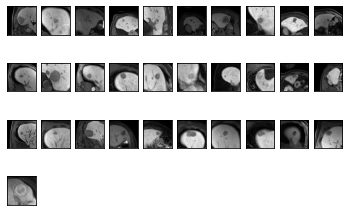

In [14]:
visualize_all(new_patients, 10, list(range(200, 231)), target_layer=crop_size[2]//2)